In [ ]:
# if using colab, install dependencies by un-commenting the line below
#!pip install gpxpy matplotlib scikit-learn

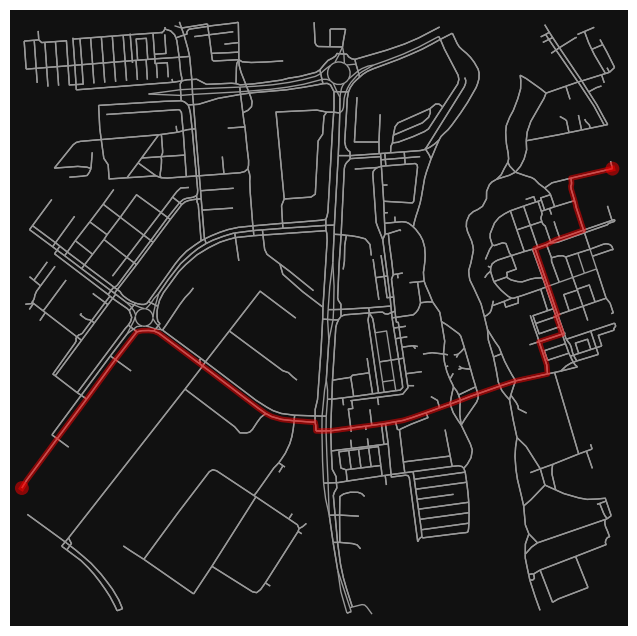

In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import LineString


from ipyleaflet import Map, Marker, Polyline, LayerGroup
from ipywidgets import VBox, HBox, Button, Output, ToggleButtons

ox.settings.use_cache = True
ox.settings.log_console = True


def _best_edge_data(G, u, v, weight="length"):
    data_dict = G.get_edge_data(u, v)
    if data_dict is None:
        raise ValueError(f"No edge data between {u} and {v}")
    best_key, best_val = None, float("inf")
    for k, data in data_dict.items():
        val = data.get(weight, 0)
        if val < best_val:
            best_val, best_key = val, k
    return best_key, data_dict[best_key]


def route_edges_gdf(G, route, weight="length", crs="EPSG:4326"):
    rows = []
    for u, v in zip(route[:-1], route[1:]):
        k, data = _best_edge_data(G, u, v, weight=weight)
        geom = data.get("geometry", None)
        if geom is None:
            x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]  # lon, lat
            x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
            geom = LineString([(x1, y1), (x2, y2)])
        rows.append({"u": u, "v": v, "key": k, "length": data.get("length"), "geometry": geom})
    return gpd.GeoDataFrame(rows, geometry="geometry", crs=crs)


def save_outputs(G, route):
    edges = route_edges_gdf(G, route)
    edges.to_file("route_edges.geojson", driver="GeoJSON")

    coords = []
    for geom in edges.geometry:
        coords.extend(list(geom.coords))
    line = LineString(coords)
    gpd.GeoDataFrame({"name": ["route"]}, geometry=[line], crs=edges.crs).to_file(
        "route.geojson", driver="GeoJSON"
    )

    fig, ax = ox.plot_graph_route(G, route, node_size=0, route_linewidth=4, show=False, close=False)
    fig.savefig("route.png", dpi=200, bbox_inches="tight")

out = Output()

mode = ToggleButtons(
    options=[("Set Start", "start"), ("Set Goal", "goal")],
    value="start",
    description="Click mode:",
)

btn_clear = Button(description="Clear", button_style="warning")
btn_route = Button(description="Route", button_style="success")

center = (62.7900123, 22.8217250)  # (lat, lon) of Seinäjoki, at least our area
m = Map(center=center, zoom=15)

layers = LayerGroup()
m.add_layer(layers)

start_marker = None
goal_marker = None
route_line = None


def _set_marker(lat, lon, kind):
    global start_marker, goal_marker

    if kind == "start":
        if start_marker is not None:
            layers.remove_layer(start_marker)
        start_marker = Marker(location=(lat, lon))
        layers.add_layer(start_marker)
    else:
        if goal_marker is not None:
            layers.remove_layer(goal_marker)
        goal_marker = Marker(location=(lat, lon))
        layers.add_layer(goal_marker)


def _clear_all(*args):
    global start_marker, goal_marker, route_line
    if start_marker is not None:
        layers.remove_layer(start_marker)
    if goal_marker is not None:
        layers.remove_layer(goal_marker)
    if route_line is not None:
        layers.remove_layer(route_line)

    start_marker = None
    goal_marker = None
    route_line = None

    with out:
        out.clear_output()
        print("Cleared. Click to set Start and Goal.")


def _compute_route(*args):
    global route_line

    with out:
        out.clear_output()

        if start_marker is None or goal_marker is None:
            print("Set both Start and Goal by clicking on the map.")
            return

        start_lat, start_lon = start_marker.location
        goal_lat, goal_lon = goal_marker.location

        print(f"Start: {start_lat:.6f}, {start_lon:.6f}")
        print(f"Goal : {goal_lat:.6f}, {goal_lon:.6f}")
        print("Downloading graph and routing...")

        mid = ((start_lat + goal_lat) / 2, (start_lon + goal_lon) / 2)
        G = ox.graph_from_point(mid, dist=500, network_type="all")

        orig = ox.distance.nearest_nodes(G, X=start_lon, Y=start_lat)
        dest = ox.distance.nearest_nodes(G, X=goal_lon, Y=goal_lat)

        route = nx.shortest_path(G, orig, dest, weight="length")


        lats_lons = []
        for node in route:
            lats_lons.append((G.nodes[node]["y"], G.nodes[node]["x"]))

        if route_line is not None:
            layers.remove_layer(route_line)

        route_line = Polyline(locations=lats_lons)
        layers.add_layer(route_line)

        save_outputs(G, route)
        print("Saved: route.geojson, route_edges.geojson, route.png")


def handle_click(**kwargs):
    if kwargs.get("type") != "click":
        return
    lat, lon = kwargs["coordinates"]
    _set_marker(lat, lon, mode.value)

m.on_interaction(handle_click)

btn_clear.on_click(_clear_all)
btn_route.on_click(_compute_route)

_clear_all()
ui = VBox([HBox([mode, btn_route, btn_clear]), m, out])
ui
